In [1]:
import ROOT

Welcome to JupyROOT 6.30/04


In [2]:
ERA = "2016postVFP"
REGION = "EB2"

In [7]:
class Electron:
    def __init__(self, era, region):
        self.pt = -999.
        self.scEta = -999.
        self.mvaNoIso = -999.
        self.miniRelIso = -999.
        self.sip3d = -999
        self.deltaR = -999.
        self.passMVANoIsoWP90 = False
        self.passMVANoIsoWPLoose = False
        self.nearestJetFlavour = -999
        self.genWeight = -999.
        self.region = region
        
        self.mvacut = -999.
        if era == "2016preVFP":
            if region == "EB1":   self.mvacut = 0.985
            elif region == "EB2": self.mvacut = 0.98
            else:                 self.mvacut = 0.75
        elif era == "2016postVFP":
            if region == "EB1":   self.mvacut = 0.985
            elif region == "EB2": self.mvacut = 0.98
            else:                 self.mvacut = 0.75
        elif era == "2017":
            if region == "EB1":   self.mvacut = 0.985
            elif region == "EB2": self.mvacut = 0.96
            else:                 self.mvacut = 0.85
        elif era == "2018":
            if region == "EB1":   self.mvacut = 0.985
            elif region == "EB2": self.mvacut = 0.96
            else:                 self.mvacut = 0.85
        else:
            raise ValueError("Invalid era")
    
    def setPt(self, pt):
        self.pt = pt
    
    def setPtCorr(self):
        self.ptCorr = self.pt*(1.0 + max(0., self.miniRelIso-0.1))
        
    def setScEta(self, scEta):
        self.scEta = scEta
        
    def setMVANoIso(self, mvaNoIso):
        self.mvaNoIso = mvaNoIso
    
    def setMiniRelIso(self, miniRelIso):
        self.miniRelIso = miniRelIso
    
    def setSIP3D(self, sip3d):
        self.sip3d = sip3d
        
    def setDeltaR(self, deltaR):
        self.deltaR = deltaR
        
    def setID(self, passMVANoIsoWP90, passMVANoIsoWPLoose):
        self.passMVANoIsoWP90 = passMVANoIsoWP90
        self.passMVANoIsoWPLoose = passMVANoIsoWPLoose
        
    def setNearestJetFlavour(self, nearestJetFlavour):
        self.nearestJetFlavour = nearestJetFlavour
        
    # Only required HcToWA Veto ID while skimming
    def passLooseID(self):
        if not (self.mvaNoIso > self.mvacut or self.passMVANoIsoWP90): return False
        if not self.miniRelIso < 0.4: return False
        if not self.sip3d < 8: return False
        return True
        
    def passTightID(self):
        if not self.passMVANoIsoWP90: return False
        if not self.miniRelIso < 0.1: return False
        if not self.sip3d < 4: return False
        return True
    
    def is_valid_region(self):
        if self.region == "EB1":
            return abs(self.scEta) < 0.8
        elif self.region == "EB2":
            return abs(self.scEta) > 0.8 and abs(self.scEta) < 1.479
        elif self.region == "EE":
            return abs(self.scEta) > 1.479 and abs(self.scEta) < 2.5
        else:
            raise ValueError(f"Region {self.region} is not valid")

In [8]:
h_ljet_loose = ROOT.TH1F("ljet_loose", "", 28, 10, 150); h_ljet_loose.SetDirectory(0)
h_cjet_loose = ROOT.TH1F("cjet_loose", "", 28, 10, 150); h_cjet_loose.SetDirectory(0)
h_bjet_loose = ROOT.TH1F("bjet_loose", "", 28, 10, 150); h_bjet_loose.SetDirectory(0)

h_ljet_tight = ROOT.TH1F("ljet_tight", "", 28, 10, 150); h_ljet_tight.SetDirectory(0)
h_cjet_tight = ROOT.TH1F("cjet_tight", "", 28, 10, 150); h_cjet_tight.SetDirectory(0)
h_bjet_tight = ROOT.TH1F("bjet_tight", "", 28, 10, 150); h_bjet_tight.SetDirectory(0)

f = ROOT.TFile.Open(f"/home/choij/workspace/ChargedHiggsAnalysisV2/SKFlatOutput/OptElLooseWP/{ERA}/OptElLooseWP_TTLL_powheg.root")
for evt in f.Events:
    electrons = []
    genWeight = evt.genWeight
    for i in range(evt.nElectrons):
        el = Electron(ERA, REGION)
        el.setPt(evt.Pt[i])
        el.setScEta(evt.scEta[i])
        el.setMVANoIso(evt.MVANoIso[i])
        el.setMiniRelIso(evt.MiniRelIso[i])
        el.setSIP3D(evt.SIP3D[i])
        el.setDeltaR(evt.DeltaR[i])
        el.setID(evt.PassMVANoIsoWP90[i], evt.PassMVANoIsoWPLoose[i])
        el.setNearestJetFlavour(evt.NearestJetFlavour[i])
        el.setPtCorr()
        if not el.is_valid_region(): continue
        electrons.append(el)
    
    for el in electrons:
        if el.deltaR > 0.4: continue
        if not el.passLooseID(): continue
        
        if el.nearestJetFlavour == 1:
            h_ljet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_ljet_tight.Fill(el.ptCorr, genWeight)
        elif el.nearestJetFlavour == 4:
            h_cjet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_cjet_tight.Fill(el.ptCorr, genWeight)
        elif el.nearestJetFlavour == 5:
            h_bjet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_bjet_tight.Fill(el.ptCorr, genWeight)
        else:
            continue
f.Close()

In [9]:
# calculate fake rate
fake_ljet = h_ljet_tight.Clone("fake_ljet"); fake_ljet.Divide(h_ljet_loose)
fake_cjet = h_cjet_tight.Clone("fake_cjet"); fake_cjet.Divide(h_cjet_loose)
fake_bjet = h_bjet_tight.Clone("fake_bjet"); fake_bjet.Divide(h_bjet_loose)

fake_ljet.SetStats(0)
fake_ljet.SetLineColor(ROOT.kBlack)
fake_ljet.SetLineWidth(2)
fake_ljet.GetXaxis().SetRangeUser(10., 100.)
fake_ljet.GetYaxis().SetRangeUser(0.01, 1.)

fake_cjet.SetStats(0)
fake_cjet.SetLineColor(ROOT.kGreen)
fake_cjet.SetLineWidth(2)

fake_bjet.SetStats(0)
fake_bjet.SetLineColor(ROOT.kBlue)
fake_bjet.SetLineWidth(2)

# Set 30% systematics in light fake rate
for bin in range(0, fake_ljet.GetNbinsX()+1):
    fake_ljet.SetBinError(bin, fake_ljet.GetBinContent(bin)*0.3)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


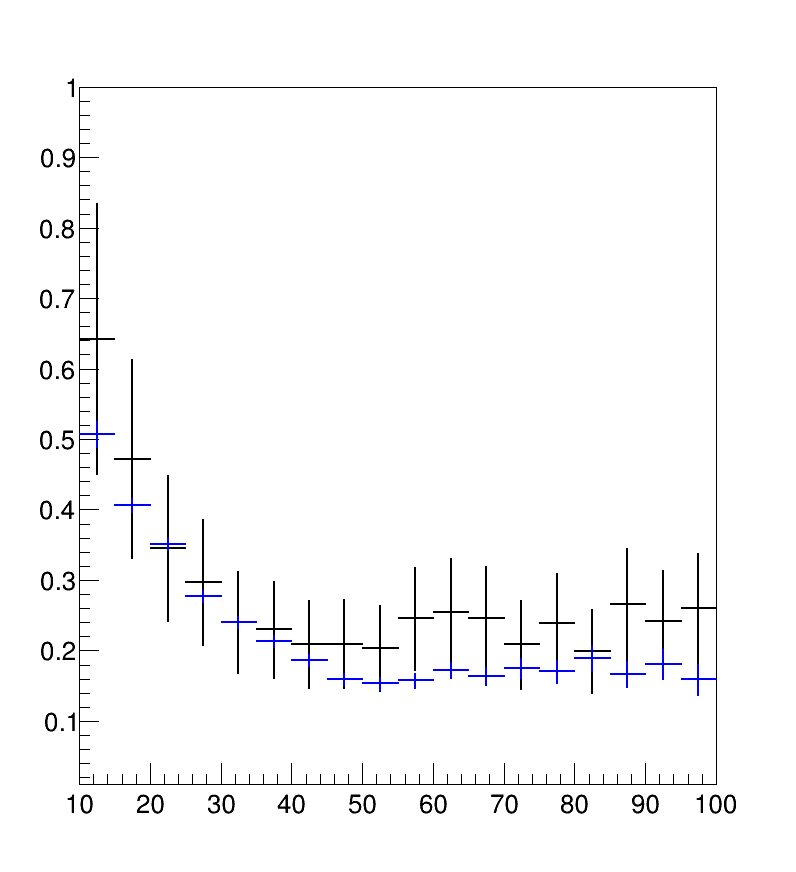

In [10]:
c = ROOT.TCanvas("cvs", "", 800, 900)
#c.SetLogy()
c.cd()
fake_ljet.Draw()
fake_bjet.Draw("same")
c.Draw()